In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [2]:
# Load MNIST
(x_train, _), _ = tf.keras.datasets.mnist.load_data()
x_train = (x_train.astype("float32") - 127.5) / 127.5
x_train = np.expand_dims(x_train, axis=-1)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [3]:
# Mapping network (style)
def mapping_network(latent_dim=100):
    inp = layers.Input(shape=(latent_dim,))
    h = layers.Dense(128, activation="relu")(inp)
    style = layers.Dense(128)(h)
    return tf.keras.Model(inp, style)

In [4]:
# Generator with AdaIN (toy version)
def build_generator(latent_dim=100):
    z = layers.Input(shape=(latent_dim,))
    style = mapping_network()(z)
    h = layers.Dense(7*7*64, activation="relu")(style)
    h = layers.Reshape((7,7,64))(h)
    x = layers.Conv2DTranspose(32, 4, strides=2, padding="same")(h)
    x = layers.LeakyReLU(0.2)(x)
    out = layers.Conv2DTranspose(1, 4, strides=2, padding="same", activation="tanh")(x)
    return tf.keras.Model(z, out)


In [5]:
# Discriminator
def build_discriminator():
    model = tf.keras.Sequential([
        layers.Conv2D(64, 3, strides=2, padding="same", input_shape=(28,28,1)),
        layers.LeakyReLU(0.2),
        layers.Flatten(),
        layers.Dense(1, activation="sigmoid")
    ])
    return model

In [6]:
generator = build_generator()
discriminator = build_discriminator()
discriminator.compile(optimizer="adam", loss="binary_crossentropy")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
z = layers.Input(shape=(100,))
img = generator(z)
discriminator.trainable = False
validity = discriminator(img)
gan = tf.keras.Model(z, validity)
gan.compile(optimizer="adam", loss="binary_crossentropy")

In [8]:
# Training
batch_size = 128
latent_dim= 100
for epoch in range(50):
    idx = np.random.randint(0, x_train.shape[0], batch_size)
    real_imgs = x_train[idx]

    noise = np.random.normal(0,1,(batch_size,100))
    fake_imgs = generator.predict(noise)

    d_loss_real = discriminator.train_on_batch(real_imgs, np.ones((batch_size,1)))
    d_loss_fake = discriminator.train_on_batch(fake_imgs, np.zeros((batch_size,1)))
    g_loss = gan.train_on_batch(noise, np.ones((batch_size,1)))

    print(f"Epoch {epoch+1} | D loss: {(d_loss_real+d_loss_fake)/2:.4f} | G loss: {g_loss:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step 


/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py:83: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 1 | D loss: 0.6990 | G loss: 0.6913
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Epoch 2 | D loss: 0.7004 | G loss: 0.6785
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Epoch 3 | D loss: 0.7058 | G loss: 0.6654
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Epoch 4 | D loss: 0.7130 | G loss: 0.6491
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Epoch 5 | D loss: 0.7236 | G loss: 0.6300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Epoch 6 | D loss: 0.7362 | G loss: 0.6089
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Epoch 7 | D loss: 0.7507 | G loss: 0.5858
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Epoch 8 | D loss: 0.7687 | G loss: 0.5613
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Epoch 9 | D loss: 0.7895 | G loss: 0.5360
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Epoch 10 | D loss: 0.8125 | G loss: 0.5113
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Epoch 11 | D loss: 0.8362 | G loss: 0.4878
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Epoch 12 | D loss: 0.8612 | G loss: 0.4655
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Epoch 13 | D loss: 0.8876 | G loss: 0

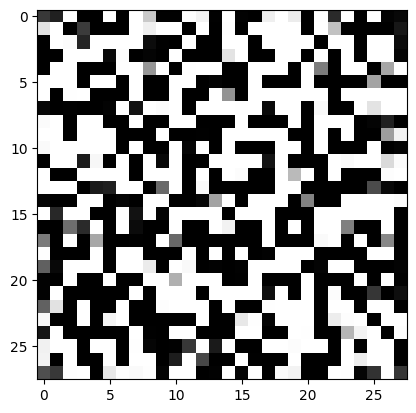

In [9]:
plt.imshow(fake_imgs[0].reshape(28,28), cmap="gray")
plt.show()